Library Imports

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb

Data Import

In [3]:
data = pd.read_csv("data/Loan_status_2007-2020Q3.gzip", index_col=0)

/var/folders/p5/qzpvt10n3xl95s2g2sx_w5c00000gn/T/ipykernel_3519/882422459.py:1: DtypeWarning: Columns (1,48,58,117,127,128,129,132,133,134,137) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("data/Loan_status_2007-2020Q3.gzip", index_col=0)


In [17]:
data.shape

(2925493, 141)

In [4]:
data.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
0,1077501,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
1,1077430,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,Ryder,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
2,1077175,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
3,1076863,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
4,1075358,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,University Medical Group,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N


Data Processing/EDA

In [18]:
# Keep subset of columns needed
ds = data[["loan_amnt", "term", "int_rate", "grade", "sub_grade", "home_ownership", "purpose", "dti", "loan_status", "revol_bal"]].dropna()

# Change "loan_status" to binary category of well performing and bad performing
ds["loan_status"] = np.where((ds["loan_status"] == "Fully Paid") | (ds["loan_status"] == "Current"), 0, 1)

# Change categorical variables to encoded labels
ds[["term", "grade", "sub_grade", "home_ownership", "purpose"]] = ds[["term", "grade", "sub_grade", "home_ownership", "purpose"]].apply(LabelEncoder().fit_transform)

# Convert string interest rate to float value
ds["int_rate"] = (ds["int_rate"].str.strip("%").astype('float64'))/100

Check to make sure table looks correct

In [20]:
ds.head()

,loan_amnt,term,int_rate,grade,sub_grade,home_ownership,purpose,dti,loan_status,revol_bal
0,5000.0,0,0.1065,1,6,5,1,27.65,0,13648.0
1,2500.0,1,0.1527,2,13,5,0,1.00,1,1687.0
2,2400.0,0,0.1596,2,14,5,11,8.72,0,2956.0
3,10000.0,0,0.1349,2,10,5,9,20.00,0,5598.0
4,3000.0,1,0.1269,1,9,5,9,17.94,0,27783.0


Split data into a set to continue preprocessing and a set to test the model with (validation)

In [21]:
ds_p, ds_val = np.split(ds.sample(frac=1), [int(0.8*len(ds))])
val_X = ds_val.drop("loan_status", axis=1)
val_y = ds_val["loan_status"]

Explore the class imbalance of our target variable

<Axes: title={'center': 'Ratio of loan types: pre downbalancing'}, ylabel='Type'>

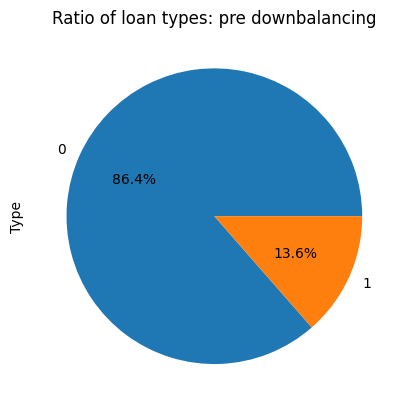

In [65]:
ds_p.groupby('loan_status').size().plot(kind='pie',
                                               y='loan_status',
                                               label='Type',
                                               title='Ratio of loan types: pre downbalancing',
                                               autopct='%1.1f%%')

In [24]:
zero_class = ds_p[ds_p["loan_status"] == 0]
one_class = ds_p[ds_p["loan_status"] == 1]

zero_downsample = resample(zero_class,
                           replace=True,
                           n_samples=int(len(one_class))*2,
                           random_state=63)

dd = pd.concat([zero_downsample, one_class])

<Axes: title={'center': 'Ratio of loan types: post downbalancing'}, ylabel='Type'>

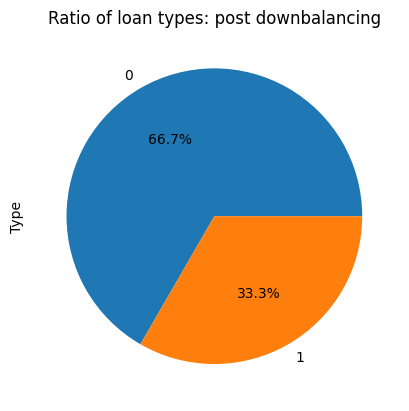

In [25]:
dd.groupby('loan_status').size().plot(kind='pie',
                                               y='loan_status',
                                               label='Type',
                                               title='Ratio of loan types: post downbalancing',
                                               autopct='%1.1f%%')

Generate Train/Test Split

In [26]:
X = dd.drop("loan_status", axis=1)
y = dd["loan_status"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42)

Building Models

In [27]:
DT = DecisionTreeClassifier()
RF = RandomForestClassifier()
XGB = xgb.XGBClassifier(n_estimators = 100)
ADA = AdaBoostClassifier(n_estimators = 100)

In [28]:
DT.fit(X_train, y_train)
RF.fit(X_train, y_train)
XGB.fit(X_train, y_train)
ADA.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100)

Evaluate Models

In [29]:
DT_pred = DT.predict(X_test)
print(f"DT test results:\n {classification_report(y_test, DT_pred)}")
DT_val_pred = DT.predict(val_X)
print(f"DT validation results:\n {classification_report(val_y, DT_val_pred)}")

DT test results:
               precision    recall  f1-score   support

           0       0.74      0.76      0.75    126886
           1       0.49      0.47      0.48     63467

    accuracy                           0.66    190353
   macro avg       0.61      0.61      0.61    190353
weighted avg       0.65      0.66      0.66    190353

DT validation results:
               precision    recall  f1-score   support

           0       0.89      0.69      0.78    505317
           1       0.19      0.47      0.27     79160

    accuracy                           0.66    584477
   macro avg       0.54      0.58      0.52    584477
weighted avg       0.80      0.66      0.71    584477



In [30]:
RF_pred = RF.predict(X_test)
print(f"RF test results:\n {classification_report(y_test, RF_pred)}")

RF_val_pred = RF.predict(val_X)
print(f"RF validation results:\n {classification_report(val_y, RF_val_pred)}")

RF test results:
               precision    recall  f1-score   support

           0       0.75      0.86      0.80    126886
           1       0.60      0.41      0.49     63467

    accuracy                           0.71    190353
   macro avg       0.67      0.64      0.64    190353
weighted avg       0.70      0.71      0.70    190353

RF validation results:
               precision    recall  f1-score   support

           0       0.90      0.82      0.86    505317
           1       0.27      0.42      0.32     79160

    accuracy                           0.77    584477
   macro avg       0.58      0.62      0.59    584477
weighted avg       0.81      0.77      0.79    584477



In [33]:
XGB_pred = XGB.predict(X_test)
print(f"XGB test results:\n {classification_report(y_test, XGB_pred)}")

XGB_val_pred = XGB.predict(val_X)
print(f"XGB validation results:\n {classification_report(val_y, XGB_val_pred)}")

XGB test results:
               precision    recall  f1-score   support

           0       0.73      0.88      0.80    126886
           1       0.60      0.36      0.45     63467

    accuracy                           0.71    190353
   macro avg       0.67      0.62      0.63    190353
weighted avg       0.69      0.71      0.68    190353

XGB validation results:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89    505317
           1       0.32      0.36      0.34     79160

    accuracy                           0.81    584477
   macro avg       0.61      0.62      0.61    584477
weighted avg       0.82      0.81      0.81    584477



In [32]:
ADA_pred = ADA.predict(X_test)
print(f"ADA test results:\n {classification_report(y_test, ADA_pred)}")

ADA_val_pred = ADA.predict(val_X)
print(f"ADA validation results:\n {classification_report(val_y, ADA_val_pred)}")

ADA test results:
               precision    recall  f1-score   support

           0       0.72      0.91      0.80    126886
           1       0.61      0.29      0.39     63467

    accuracy                           0.70    190353
   macro avg       0.67      0.60      0.60    190353
weighted avg       0.68      0.70      0.67    190353

ADA validation results:
               precision    recall  f1-score   support

           0       0.89      0.91      0.90    505317
           1       0.33      0.29      0.31     79160

    accuracy                           0.82    584477
   macro avg       0.61      0.60      0.60    584477
weighted avg       0.81      0.82      0.82    584477

